In [2]:
#STEP 1: LOAD DATA
import pandas as pd

df = pd.read_csv("../data/processed/preprocessed_phase3.csv")
df.shape


(115617, 40)

In [3]:
#STEP 2: DEFINE TARGET AND FEATURES
y = df["habitable"]
X = df.drop(columns=["habitable"])


In [4]:
#STEP 3: REMOVE LEAKAGE FEATURES (CRITICAL)
leakage_cols = [
    "habitability_index",
    "temp_score",
    "radius_score",
    "distance_score",
    "luminosity_score"
]

X = X.drop(columns=leakage_cols, errors="ignore")


In [5]:
#STEP 4: KEEP ONLY NUMERIC FEATURES
X = X.select_dtypes(include=["number"])

In [6]:
#STEP 5: TRAIN–TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((92493, 28), (23124, 28))

In [7]:
#STEP 6: Logistic Regression (Baseline Model)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

pipe_lr.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [8]:
#STEP 7: Random Forest Model
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ))
])

pipe_rf.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

In [9]:
#STEP 8: XGBoost Model
from xgboost import XGBClassifier

pipe_xgb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ))
])

pipe_xgb.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [10]:
#step 9:MODEL EVALUATION
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Results")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("ROC–AUC  :", roc_auc_score(y_test, y_prob))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"{name} Confusion Matrix")
    plt.show()



Logistic Regression Results
Accuracy : 0.9948105864037364
Precision: 0.9980844579886808
Recall   : 0.9915232246345472
F1 Score : 0.9947930226503515
ROC–AUC  : 0.9999602782298301

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     11563
           1       1.00      0.99      0.99     11561

    accuracy                           0.99     23124
   macro avg       0.99      0.99      0.99     23124
weighted avg       0.99      0.99      0.99     23124



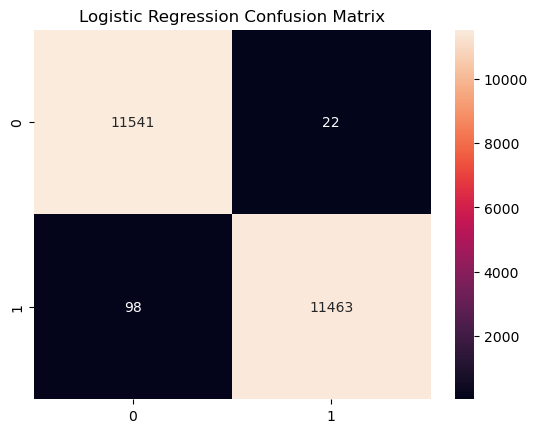


Random Forest Results
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0
ROC–AUC  : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11563
           1       1.00      1.00      1.00     11561

    accuracy                           1.00     23124
   macro avg       1.00      1.00      1.00     23124
weighted avg       1.00      1.00      1.00     23124



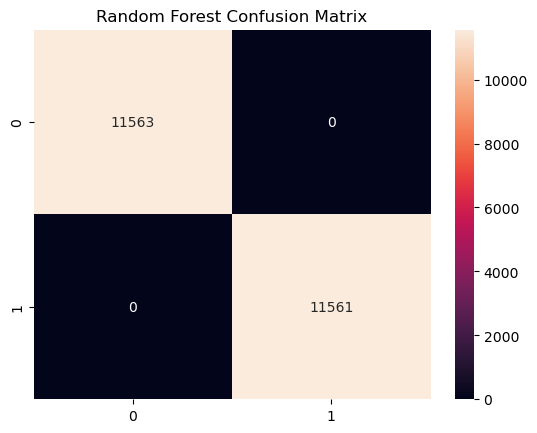


XGBoost Results
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0
ROC–AUC  : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11563
           1       1.00      1.00      1.00     11561

    accuracy                           1.00     23124
   macro avg       1.00      1.00      1.00     23124
weighted avg       1.00      1.00      1.00     23124



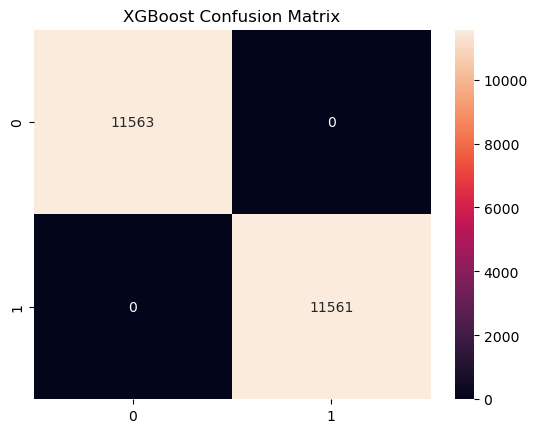

In [11]:
evaluate_model(pipe_lr, X_test, y_test, "Logistic Regression")
evaluate_model(pipe_rf, X_test, y_test, "Random Forest")
evaluate_model(pipe_xgb, X_test, y_test, "XGBoost")


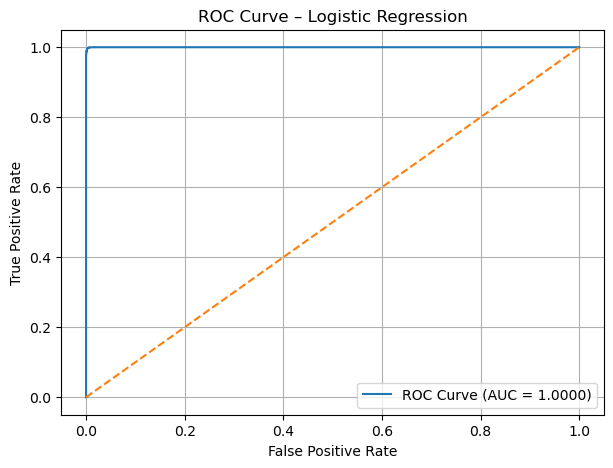

In [12]:
#Step 10:PLOT ROC CURVE
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities
y_prob = pipe_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")  # random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [13]:
#STEP 11: Save FINAL MODEL
import joblib
joblib.dump(pipe_lr, "../models/logistic_regression_final.pkl")


['../models/logistic_regression_final.pkl']

In [14]:
#STEP 12: Habitability Scoring & Ranking
probs = pipe_lr.predict_proba(X_test)[:, 1]

ranking = pd.DataFrame({
    "habitability_probability": probs
}).sort_values(by="habitability_probability", ascending=False)

ranking.to_csv("../data/processed/habitability_ranked.csv", index=False)


In [15]:
#STEP 13: ML Output CSV
ml_output = pd.DataFrame({
    "actual_habitable": y_test.values,
    "predicted_habitable": pipe_lr.predict(X_test),
    "habitability_probability": probs
})

ml_output.to_csv("../data/processed/ml_model_output.csv", index=False)


In [16]:
X.columns.tolist()


['pl_rade',
 'pl_orbper',
 'pl_orbsmax',
 'pl_eqt',
 'st_teff',
 'st_rad',
 'st_mass',
 'st_met',
 'disc_year',
 'default_flag',
 'pl_bmasse',
 'pl_density',
 'st_luminosity',
 'pl_eqt_norm',
 'pl_rade_norm',
 'pl_orbsmax_norm',
 'st_luminosity_norm',
 'st_teff_norm',
 'st_rad_norm',
 'st_lum_norm',
 'temp_star_score',
 'size_star_score',
 'radiation_score',
 'stellar_compatibility_index',
 'pl_orbper_norm',
 'period_stability_score',
 'distance_stability_score',
 'orbital_stability_factor']

In [17]:
print(X.columns)


Index(['pl_rade', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'st_teff', 'st_rad',
       'st_mass', 'st_met', 'disc_year', 'default_flag', 'pl_bmasse',
       'pl_density', 'st_luminosity', 'pl_eqt_norm', 'pl_rade_norm',
       'pl_orbsmax_norm', 'st_luminosity_norm', 'st_teff_norm', 'st_rad_norm',
       'st_lum_norm', 'temp_star_score', 'size_star_score', 'radiation_score',
       'stellar_compatibility_index', 'pl_orbper_norm',
       'period_stability_score', 'distance_stability_score',
       'orbital_stability_factor'],
      dtype='object')
